In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 16.0)

In [2]:
S = 10.
B = 8./3
R = 28
START = (1., 1., 1.)

In [3]:
T = 250.
dt = 1E-2
N = int(T/dt)
TIME = np.linspace(0, T, N)

In [4]:
def lorenz(x, y, z, r=R, s=S, b=B):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

In [5]:
def annotate(plt, text, arrow_to, text_pos):
    bbox = {
    'boxstyle': 'round,pad=1',
    'fc': 'yellow',
    'alpha': 0.5
    }
    arrow = {
        'arrowstyle': '->',
        'connectionstyle': 'arc3,rad=0'
    }
    return plt.annotate(text,
                        xy=arrow_to,
                        xytext=text_pos,
                        bbox=bbox,
                        arrowprops=arrow)

In [6]:
xs_ = np.empty_like(TIME)
ys_ = np.empty_like(TIME)
zs_ = np.empty_like(TIME)
xs_[0], ys_[0], zs_[0] = START

In [7]:
for i in range(len(TIME) - 1):
    dx, dy, dz = lorenz(xs_[i], ys_[i], zs_[i])
    xs_[i+1] = xs_[i] + dx * dt
    ys_[i+1] = ys_[i] + dy * dt
    zs_[i+1] = zs_[i] + dz * dt

In [8]:
phase_volume = xs_ * ys_ * zs_
global_min = phase_volume.argmin()
local_max = np.argwhere(phase_volume[global_min:-1] - phase_volume[global_min+1:] > 0)[0][0]
local_flat = np.argwhere(phase_volume[local_max:-1] - phase_volume[local_max+1:] > 0)[0][0]
T_INI = global_min + local_max + local_flat

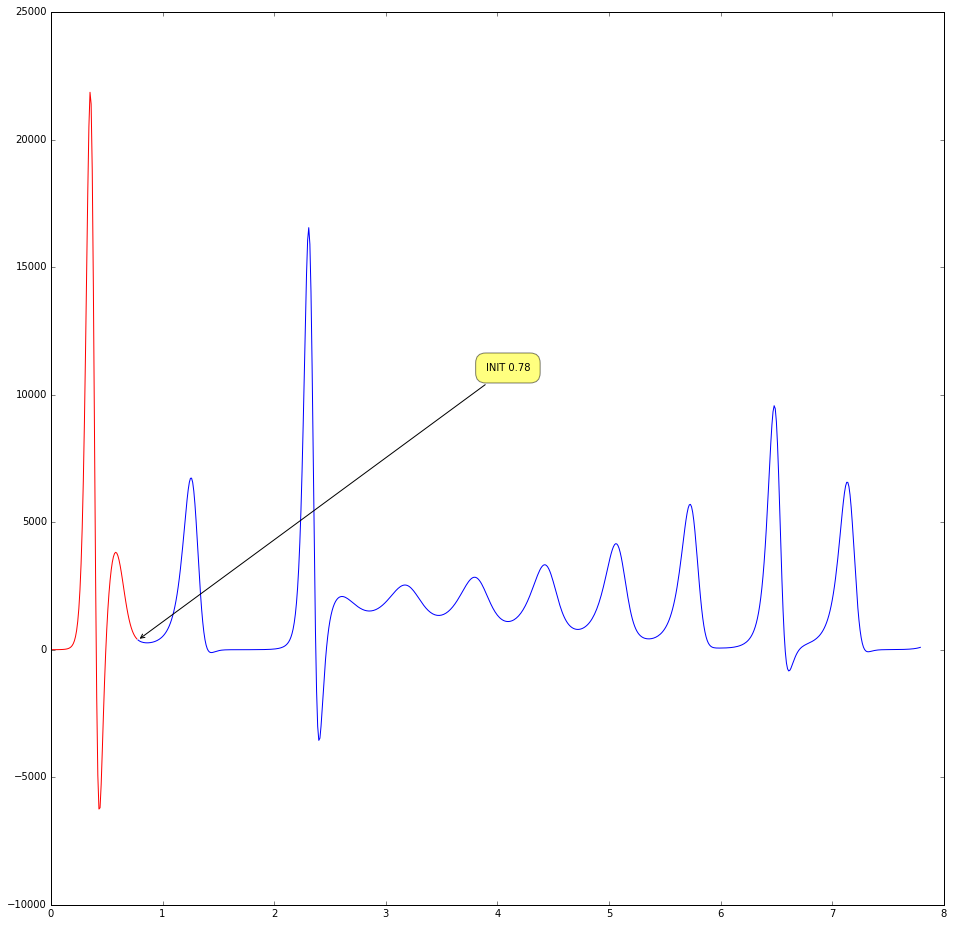

In [9]:
volume_intervals = T_INI*10
volume_time = TIME[:volume_intervals]
plt.plot(volume_time[:T_INI], phase_volume[:T_INI], 'r')
plt.plot(volume_time[T_INI:], phase_volume[T_INI:volume_intervals])

annotate(plt, 'INIT %4.2f'%TIME[T_INI],
         (TIME[T_INI], phase_volume[T_INI]), (volume_time.max()/2, phase_volume.max()/2))
plt.show()

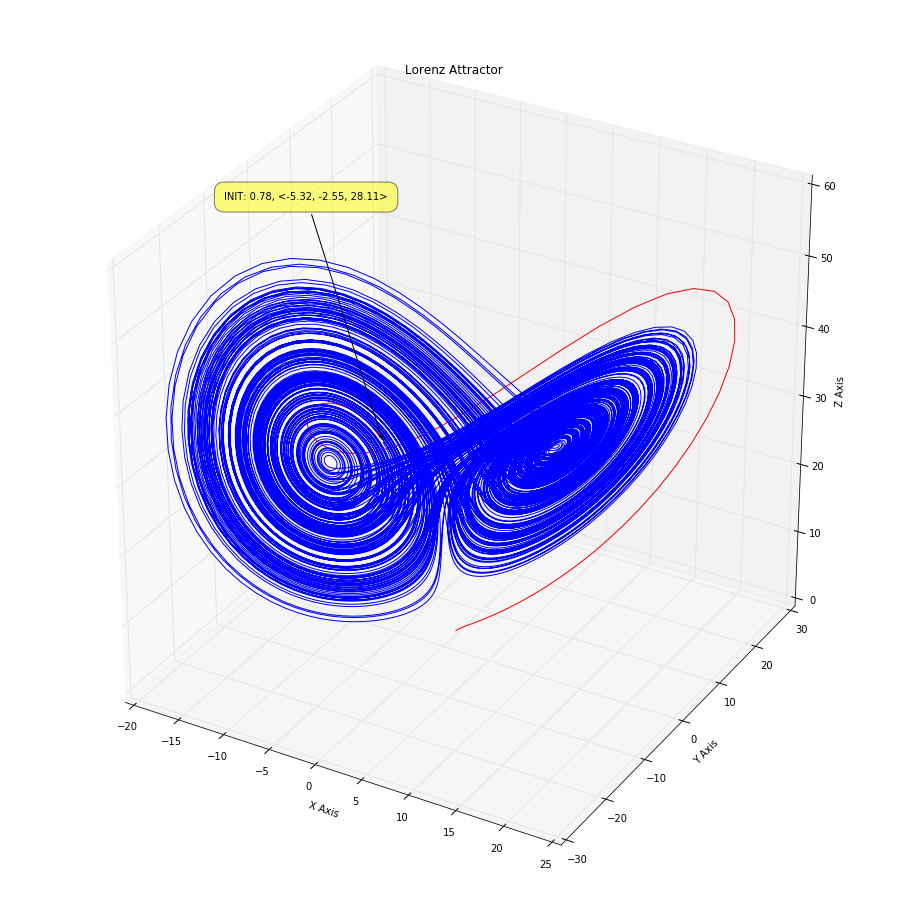

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs_[:T_INI], ys_[:T_INI], zs_[:T_INI], 'r')
ax.plot(xs_[T_INI:], ys_[T_INI:], zs_[T_INI:])
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

x_ini, y_ini, _ = proj3d.proj_transform(xs_[T_INI], ys_[T_INI], zs_[T_INI], ax.get_proj())
annotate(plt, 'INIT: {:4.2f}, <{:4.2f}, {:4.2f}, {:4.2f}>'.format(TIME[T_INI], xs_[T_INI], ys_[T_INI], zs_[T_INI]),
         (x_ini, y_ini), (-0.05, .05))

plt.show()

In [11]:
xs, ys, zs = xs_[T_INI:], ys_[T_INI:], zs_[T_INI:]
N_MAX = N - T_INI
assert len(xs) == N_MAX and len(ys) == N_MAX and len(xs) == N_MAX

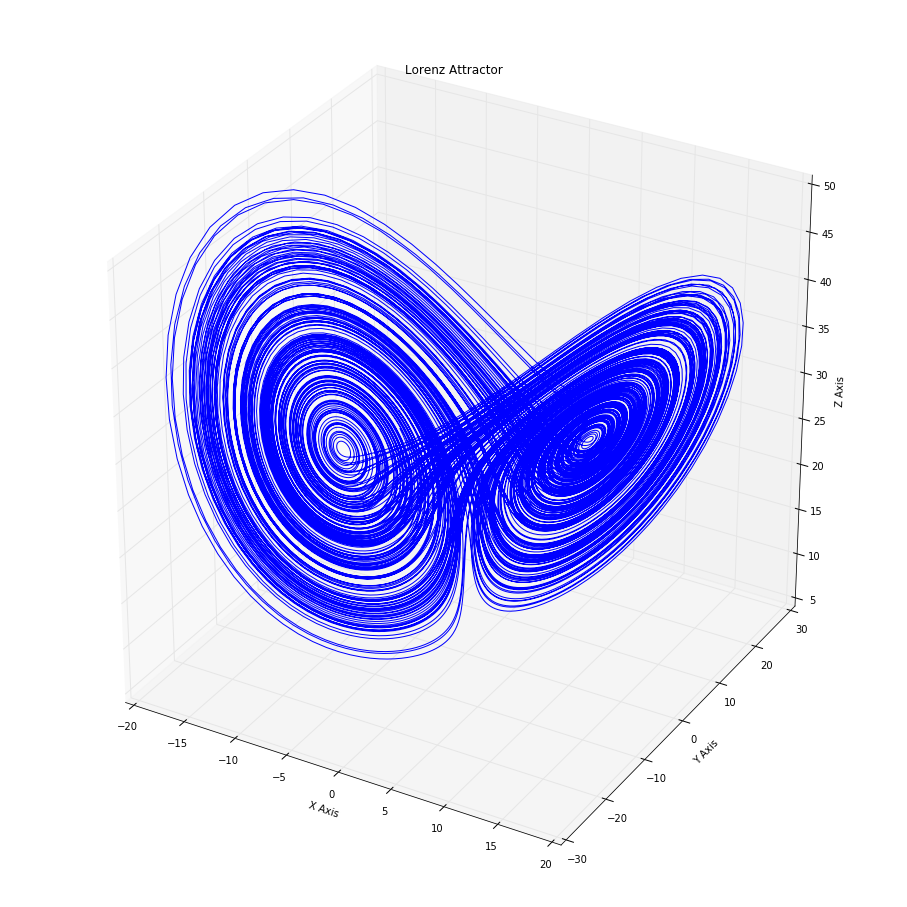

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [21]:
def R(t, sequence):
    if t == 0:
        seq1 = sequence[:]
    else:
        seq1 = sequence[:-t]
    seq2 = sequence[t:]
    return (seq1 * seq2).mean()

In [50]:
autocorr = [np.array([R(t, s) for t in range(N_MAX)]) for s in (xs, ys, zs)]
local_min = [np.argwhere(s[:-1] - s[1:] < 0)[0][0] for s in autocorr]

In [64]:
TIME_ = TIME[T_INI:]
end = min(local_min)*10
graphical_info = (('r', 'X'), ('g', 'Y'), ('b', 'Z'))
for lm, ac, g in zip(local_min[0], autocorr[0], graphical_info[0]):
    plt.plot(TIME_[:lm], ac[:lm], g[0] + '--', label=g[1])
    plt.plot(TIME_[lm:end], ac[lm:end], g[0], label='%s tail'%g[1])

plt.legend()
plt.show()

TypeError: zip argument #1 must support iteration